In [587]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.signal as sgn
from astropy.modeling import models
from scipy.optimize import curve_fit
from scipy.constants import speed_of_light as light
from scipy.constants import Boltzmann as kb
from scipy.constants import Avogadro as avo

In [588]:
#constants
mass87 = 87e-3/avo
mass85 = 85e-3/avo

#rb87 transitions 
sp_87 = +384.230484468e12
s1_87 = +4.271676e9
s2_87 = -2.563005e9
p0_87 = -302.074e6
p1_87 = -229.852e6
p2_87 = -072.991e6
p3_87 = +193.741e6

#rb85 transitions
sp_85 = +384.230406373e12
s1_85 = +1.770843e9
s2_85 = -1.264888e9
p0_85 = -113.208e6
p1_85 = -083.835e6
p2_85 = -020.445e6
p3_85 = +100.205e6

#need transitions for evaluation
cross87_s2_p23 = sp_87 + s2_87 + (p2_87 + p3_87)/2
cross87_s1_p12 = sp_87 + s1_87 + (p1_87 + p2_87)/2

clean87_s1_p2 = sp_87 + s1_87 + p2_87
clean87_s2_p1 = sp_87 + s2_87 + p1_87

clean87_s1 = sp_87 + s1_87
clean87_s2 = sp_87 + s2_87

clean85_s1 = sp_85 + s1_85
clean85_s2 = sp_85 + s2_85

dif87_85 = clean85_s2 - clean87_s2
dif85_85 = s1_85 - s2_85
dif85_87 = clean87_s1 - clean85_s1

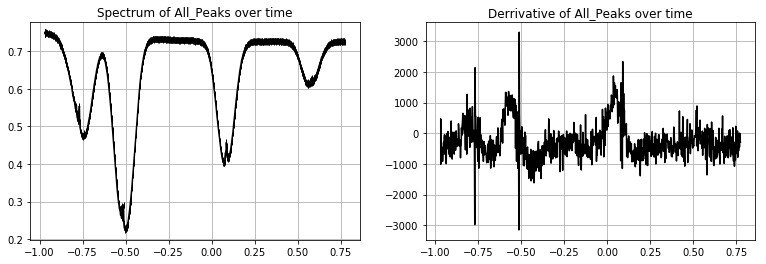

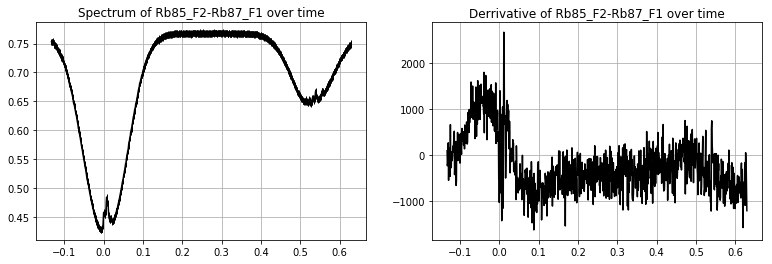

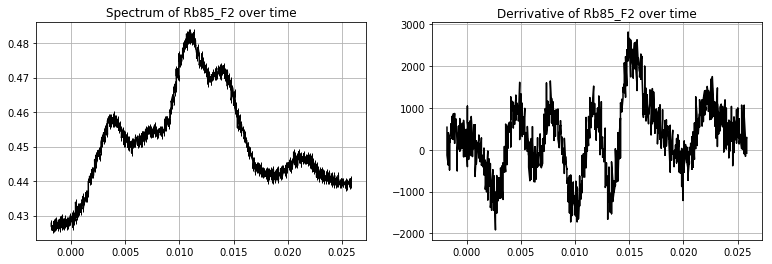

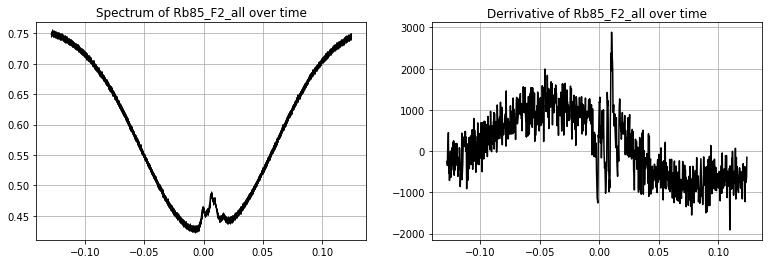

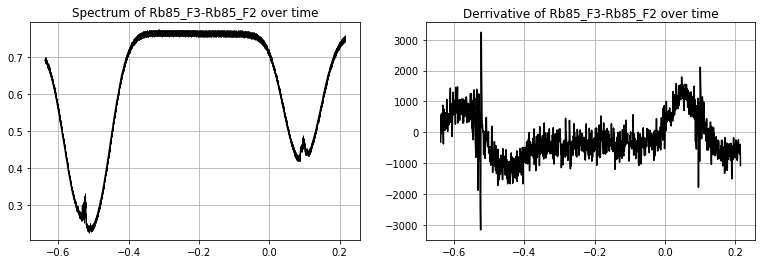

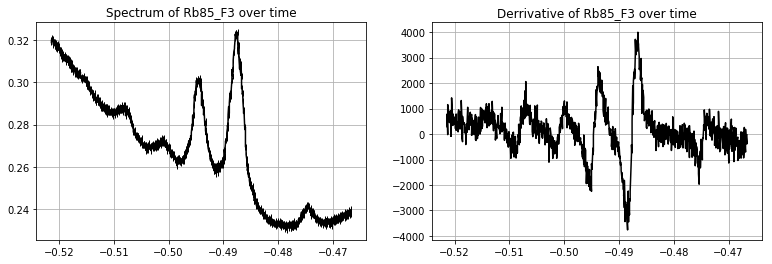

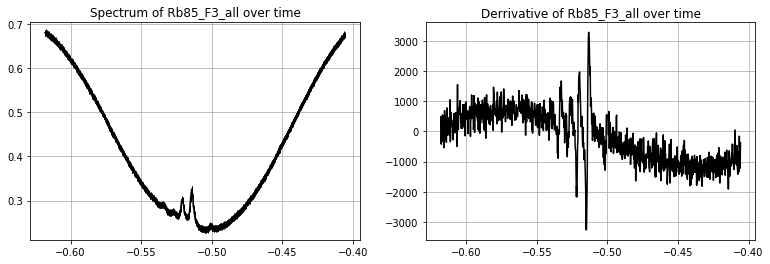

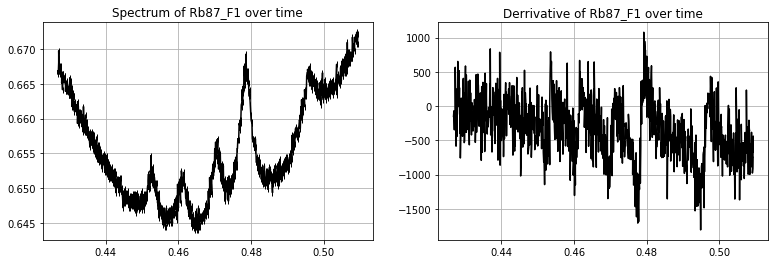

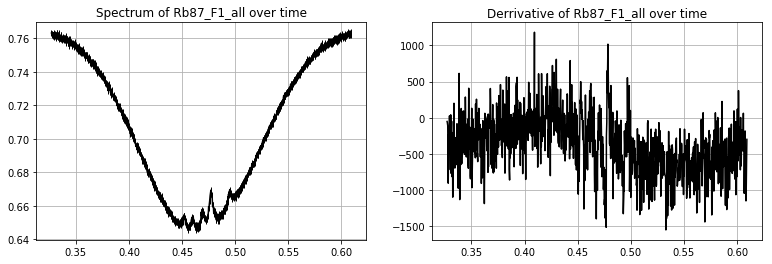

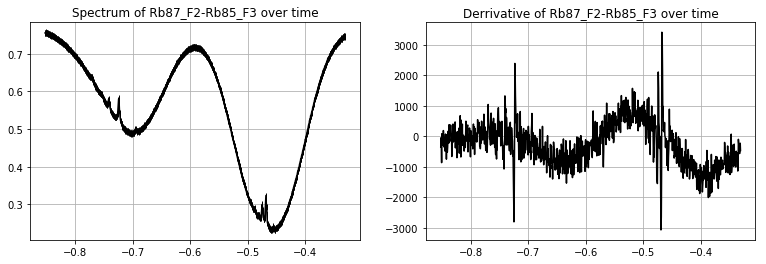

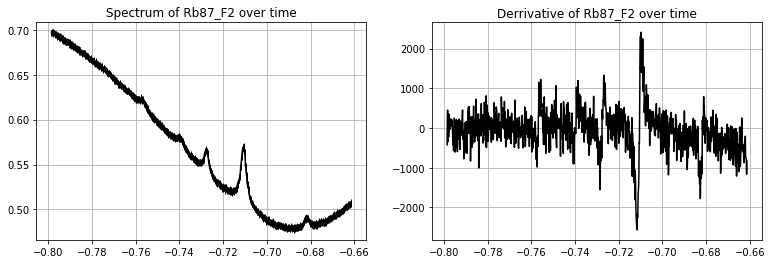

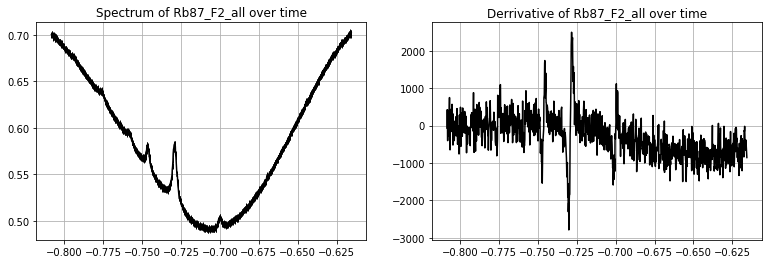

In [589]:
dic = {}

for file in glob.glob('Part I/*.txt'):
    t,i,d = np.loadtxt(file,skiprows=1,usecols=(0,1,2),unpack=True)
    dic.setdefault(file[7:-4],[t,i,diff])
    plt.figure(figsize=(13,4))
    plt.subplot(1,2,1)
    plt.plot(t,i,'k|-')
    plt.title('Spectrum of '+file[7:-4]+' over time')
    plt.grid(True)
    plt.subplot(1,2,2)
    plt.plot(t,d,'k-')
    plt.title('Derrivative of '+file[7:-4]+' over time')
    plt.grid(True)
    plt.show()
    del t,i,d

# 1.Calibration

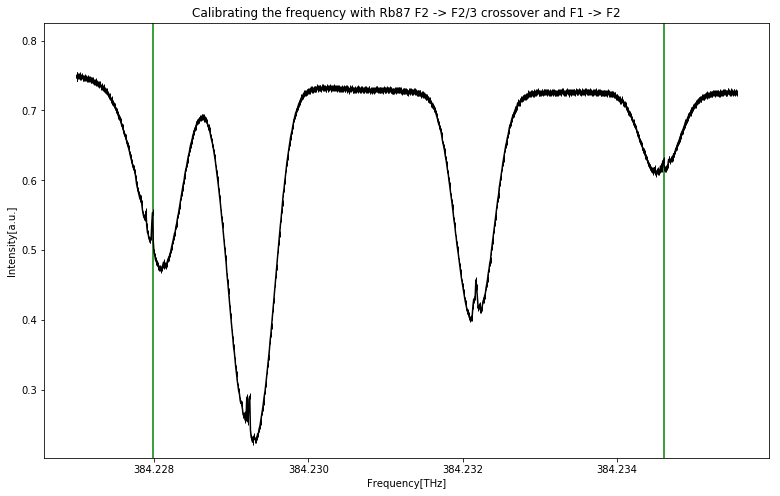

dict_keys(['All_Peaks', 'Rb85_F2-Rb87_F1', 'Rb85_F2', 'Rb85_F2_all', 'Rb85_F3-Rb85_F2', 'Rb85_F3', 'Rb85_F3_all', 'Rb87_F1', 'Rb87_F1_all', 'Rb87_F2-Rb85_F3', 'Rb87_F2', 'Rb87_F2_all'])


In [590]:
def readout(key, order):
    t,i,d = dic[key]
    mask = sgn.argrelmax(i,order=order,mode='wrap')
    mask_d = (i[mask] < 0.68) #& (np.abs(d[mask]) < 30)
    t_p = t[mask][mask_d]
    return t_p,t,i,d

t_p,t,i,d = readout('All_Peaks',6)
zero = t_p[0]
scale = (cross87_s1_p12-cross87_s2_p23)/(t_p[-1]-zero)

def scaling(t):
    return (cross87_s2_p23+(t-zero)*scale)*1e-12

def gaussian(x,fac,mean,std,off):
    return fac*np.exp(-(x-mean)**2/(2*std**2))+off

def lorentzian(x,fac,mean,fwhm):
    return fac/(1+((mean-x)/(0.5*fwhm))**2)

def temperature87(wid, wave):
    sig = wid*1e12
    return (sig**2/(wave*1e12)**2)*mass87*light**2/kb

def temperature85(wid, wave):
    sig = wid*1e12
    return (sig**2/(wave*1e12)**2)*mass87*light**2/kb

t = scaling(t)
t_p = scaling(t_p)

plt.figure(figsize=(13,8))
plt.vlines(t_p[::3],np.min(i)*0.9,np.max(i)*1.1,colors='green')
plt.ylim(np.min(i)*0.9,np.max(i)*1.1)
plt.plot(t,i,'k|-')
plt.title('Calibrating the frequency with Rb87 F2 -> F2/3 crossover and F1 -> F2')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
del t,i,d,t_p
print(dic.keys())

# 2. Mulitpletes

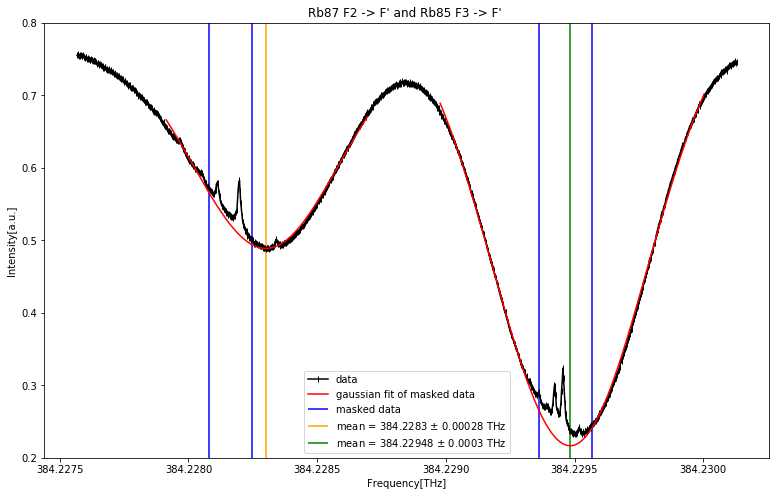

Difference calculated from measurements = 1.182378 +/- 0.412039 GHz
The error of the parameter is: 0.000615 GHz
The error is 34.8% of the mean
Literature = 1.220022 GHz
Diviation from Literature = 0.037644 GHz or 0.091 Sigma


In [591]:
t_p,t,i,d = readout('Rb87_F2-Rb85_F3',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

down = 135
hole1 = 200
hole2 = 265
up = 440

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
err1 = np.sqrt(pcov[1,1])
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue',label='masked data')
plt.vlines(popt[1],0.2,0.8,color='orange',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) +' THz')
plt.plot(x,gaussian(x,*popt),'r-',label='gaussian fit of masked data')

down = 550
hole1 = 700
hole2 = 780
up = 950

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean2 = popt[1]
std2 = popt[2]
err2 = np.sqrt(pcov[1,1])
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue')
plt.vlines(popt[1],0.2,0.8,color='green',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) + ' THz')
plt.plot(x,gaussian(x,*popt),'r-')

plt.ylim(0.2,0.8)
plt.title('Rb87 F2 -> F\' and Rb85 F3 -> F\' ')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=8)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

#TODO what literature values are meant for the difference between these multipletes
print('Difference calculated from measurements = '+str(round((mean2-mean1)*1000,6))+' +/- '+
      str(round(np.sqrt(std2**2+std1**2)*1000,6)) + ' GHz' )
print('The error of the parameter is: '+str(round(np.sqrt(err2**2+err1**2)*1000,6))+' GHz')
print('The error is '+str(round(np.sqrt(std2**2+std1**2)/(mean2-mean1)*100,1))+'% of the mean')
print('Literature = '+str(round(dif87_85*1e-9,6))+' GHz')
print('Diviation from Literature = '+str(round(-(mean2-mean1)*1000+dif87_85*1e-9,6))+' GHz or '
    +str(round((-(mean2-mean1)*1000+dif87_85*1e-9)/np.sqrt(std2**2+std1**2)/1000,3))+' Sigma')

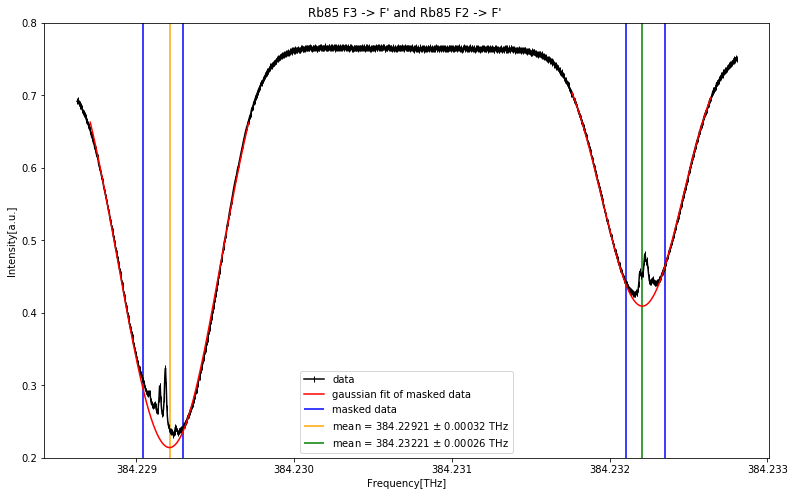

Difference calculated from measurements = 2.997498 +/- 0.411083 GHz
The Error is 13.7% of the mean
Literature = 3.035731 GHz
Diviation from Literature = 0.038233 GHz or 0.093 Sigma


In [592]:
t_p,t,i,d = readout('Rb85_F3-Rb85_F2',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

down = 20
hole1 = 100
hole2 = 160
up = 260

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue',label='masked data')
plt.vlines(popt[1],0.2,0.8,color='orange',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) +' THz')
plt.plot(x,gaussian(x,*popt),'r-',label='gaussian fit of masked data')

down = 750
hole1 = 832
hole2 = 890
up = 960

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean2 = popt[1]
std2 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue')
plt.vlines(popt[1],0.2,0.8,color='green',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) + ' THz')
plt.plot(x,gaussian(x,*popt),'r-')

plt.ylim(0.2,0.8)
plt.title('Rb85 F3 -> F\' and Rb85 F2 -> F\' ')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=8)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()


print('Difference calculated from measurements = '+str(round((mean2-mean1)*1000,6))+' +/- '
      +str(round(np.sqrt(std2**2+std1**2)*1000,6)) + ' GHz' )
print('The Error is '+str(round(np.sqrt(std2**2+std1**2)/(mean2-mean1)*100,1))+'% of the mean')
print('Literature = '+str(dif85_85*1e-9)+' GHz')
print('Diviation from Literature = '+str(round(-(mean2-mean1)*1000+dif85_85*1e-9,6))+' GHz or '
      +str(round((-(mean2-mean1)*1000+dif85_85*1e-9)/np.sqrt(std2**2+std1**2)/1000,3))+' Sigma')

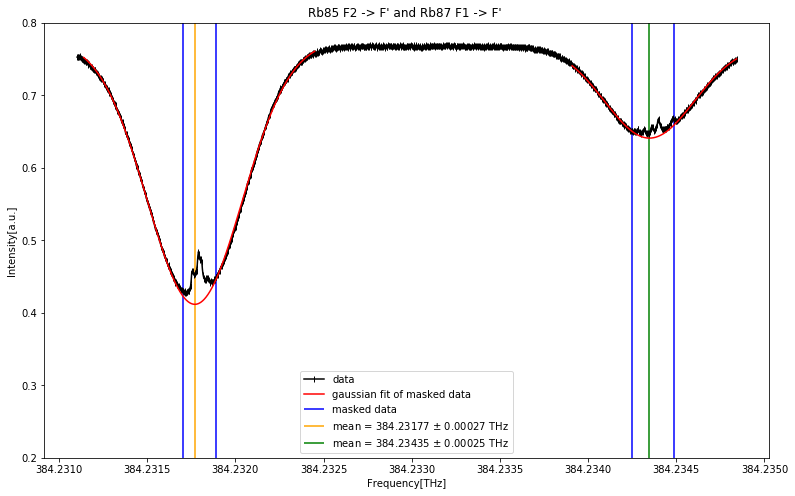

Difference calculated from measurements = 2.577498 +/- 0.370205 GHz
The Error is 14.4% of the mean
Literature = 2.578928 GHz
Diviation from Literature = -0.00143 GHz or -0.004 Sigma


In [593]:
t_p,t,i,d = readout('Rb85_F2-Rb87_F1',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

down = 10
hole1 = 160
hole2 = 210
up = 360

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue',label='masked data')
plt.vlines(popt[1],0.2,0.8,color='orange',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) +' THz')
plt.plot(x,gaussian(x,*popt),'r-',label='gaussian fit of masked data')

down = 750
hole1 = 840
hole2 = 905
up = 999

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean2 = popt[1]
std2 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='blue')
plt.vlines(popt[1],0.2,0.8,color='green',label='mean = '+str(round(popt[1],5))+' $\pm$ '+
           str(round(popt[2],5)) + ' THz')
plt.plot(x,gaussian(x,*popt),'r-')

plt.ylim(0.2,0.8)
plt.title('Rb85 F2 -> F\' and Rb87 F1 -> F\' ')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=8)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

#TODO: Which difference do we compare it to?
print('Difference calculated from measurements = '+str(round((mean2-mean1)*1000,6))+' +/- '
      +str(round(np.sqrt(std2**2+std1**2)*1000,6)) + ' GHz' )
print('The Error is '+str(round(np.sqrt(std2**2+std1**2)/(mean2-mean1)*100,1))+'% of the mean')
print('Literature = '+str(round(dif85_87*1e-9,6))+' GHz')
print('Diviation from Literature = '+str(-round((mean2-mean1)*1000dif85_87*1e-9,6))+' GHz or '
    +str(round(((mean2-mean1)*1000-dif85_87*1e-9)/np.sqrt(std2**2+std1**2)/1000,3))+' Sigma')

# 3. Natural transition line width

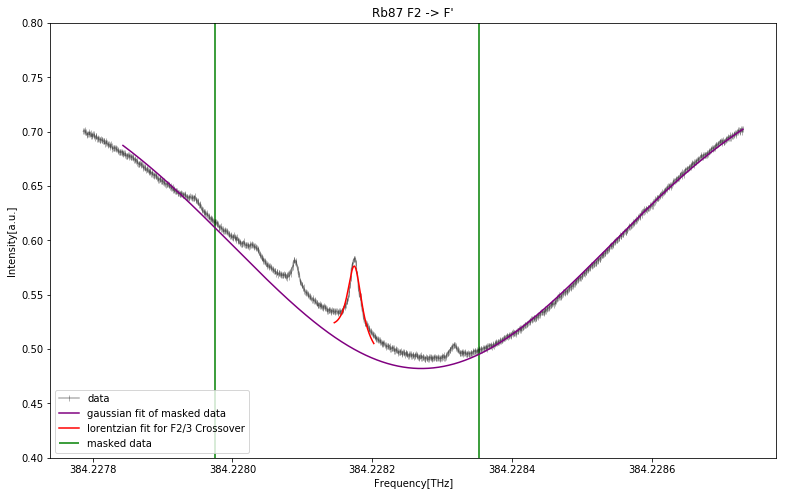

The Temperature is :  464.41  K
The Temperature if we take the Literature frequency is :  464.41  K
The natural transition line width is :  26.18  +/-  0.96  MHz


In [594]:
t_p,t,i,d = readout('Rb87_F2_all',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',alpha=0.3,label='data')

down = 60
hole1 =200
hole2 = 600
up = 999

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='green',label='masked data')
plt.plot(x,gaussian(x,*popt),color='purple',label='gaussian fit of masked data')

down = 380
up = 440
x = np.linspace(t[down],t[up],10000)
back = gaussian(x,*popt)
t_l = t[down:up] 
i_l = i[down:up] - gaussian(t_l,*popt)
popt, pcov = curve_fit(lorentzian,t_l,i_l,[0.08,384.22818,0.0000026])
mean = popt[1]
FWHM = popt[2]

plt.plot(x,lorentzian(x,*popt) + back,'r-',label='lorentzian fit for F2/3 Crossover')

plt.ylim(0.4,0.8)
plt.title('Rb87 F2 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('The Temperature is : ',round(temperature87(std1,mean1),2),' K')
print('The Temperature if we take the Literature frequency is : '
      ,round(temperature87(std1,(sp_87+s2_87)*1e-12),2),' K')
print('The natural transition line width is : ',round(FWHM*1e6,2),' +/- ',
      round(np.sqrt(pcov[2,2])*1e6,2),' MHz')

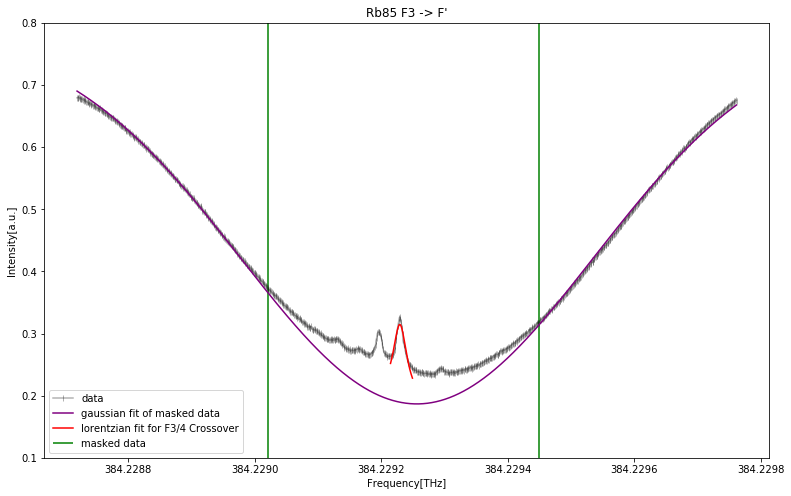

The Temperature is :  495.21  K
The natural transition line width is :  27.83  +/-  1.6  MHz


In [602]:
t_p,t,i,d = readout('Rb85_F3_all',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',alpha=0.3,label='data')

down = 0
hole1 = 290
hole2 = 700
up = 999

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.1,0.8,color='green',label='masked data')
plt.plot(x,gaussian(x,*popt),color='purple',label='gaussian fit of masked data')

down = 475
up = 508
x = np.linspace(t[down],t[up],10000)
back = gaussian(x,*popt)
t_l = t[down:up] 
i_l = i[down:up] - gaussian(t_l,*popt)
popt, pcov = curve_fit(lorentzian,t_l,i_l,[0.03,384.2293,0.0002])
mean = popt[1]
FWHM = popt[2]

plt.plot(x,lorentzian(x,*popt) + back,'r-',label='lorentzian fit for F3/4 Crossover')

plt.ylim(0.1,0.8)
plt.title('Rb85 F3 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('The Temperature is : ',round(temperature85(std1, mean1),2),' K')
print('The natural transition line width is : ',round(FWHM*1e6,2),' +/- ',
      round(np.sqrt(pcov[2,2])*1e6,2),' MHz')

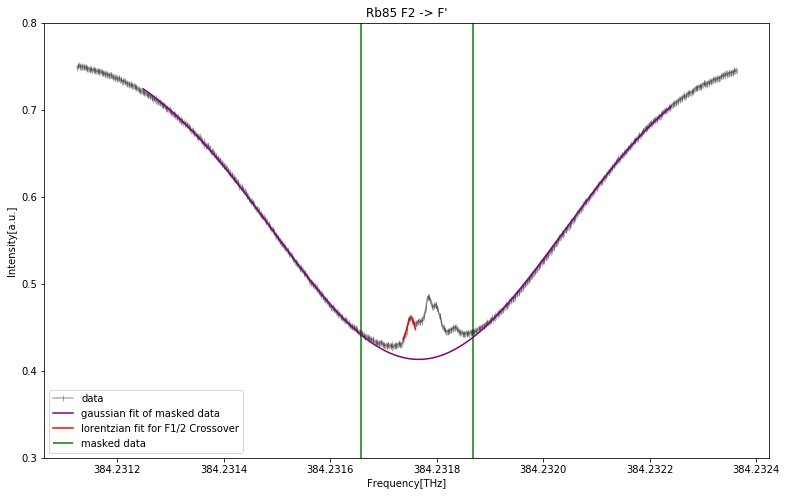

The Temperature is  469.84  K
The natural transition line width is :  25.97  +/-  0.97  MHz


In [596]:
t_p,t,i,d = readout('Rb85_F2_all',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',alpha=0.3,label='data')

down = 100
hole1 = 430
hole2 = 600
up = 900

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='green',label='masked data')
plt.plot(x,gaussian(x,*popt),color='purple',label='gaussian fit of masked data')

down = 494
up = 513
x = np.linspace(t[down],t[up],10000)
back = gaussian(x,*popt)
t_l = t[down:up] 
i_l = i[down:up] - gaussian(t_l,*popt)
popt, pcov = curve_fit(lorentzian,t_l,i_l,[0.04,t[504],0.00001])
mean = popt[1]
FWHM = popt[2]

plt.plot(x,lorentzian(x,*popt) + back,'r-',label='lorentzian fit for F1/2 Crossover')

plt.ylim(0.3,0.8)
plt.title('Rb85 F2 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('The Temperature is ',round(temperature85(std1, mean1),2),' K')
print('The natural transition line width is : ',round(FWHM*1e6,2),' +/- ',
      round(np.sqrt(pcov[2,2])*1e6,2),' MHz')

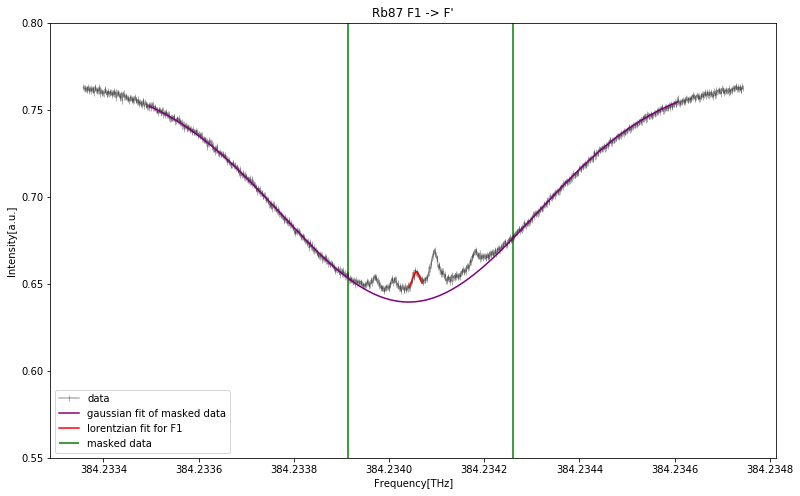

The Temperature is  459.2  K
The natural transition line width is :  29.15  +/-  2.16  MHz


In [597]:
t_p,t,i,d = readout('Rb87_F1_all',6)
t = scaling(t)
t_p = scaling(t_p)
plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',alpha=0.3,label='data')

down = 100
hole1 = 400
hole2 = 650
up = 900

t_eff = np.append(t[down:hole1],t[hole2:up])
i_eff = np.append(i[down:hole1],i[hole2:up])

popt, pcov = curve_fit(gaussian,t_eff,i_eff,p0=[-1,t_eff[i_eff == np.min(i_eff)][0],0.0002,0.8])
mean1 = popt[1] 
std1 = popt[2]
x = np.linspace(t[down],t[up],10000)
plt.vlines([t[hole1],t[hole2]],0.2,0.8,color='green',label='masked data')
plt.plot(x,gaussian(x,*popt),color='purple',label='gaussian fit of masked data')

down = 494
up = 513
x = np.linspace(t[down],t[up],10000)
back = gaussian(x,*popt)
t_l = t[down:up] 
i_l = i[down:up] - gaussian(t_l,*popt)
popt, pcov = curve_fit(lorentzian,t_l,i_l,[0.04,t[504],0.00001])
mean = popt[1]
FWHM = popt[2]

plt.plot(x,lorentzian(x,*popt) + back,'r-',label='lorentzian fit for F1')

plt.ylim(0.55,0.8)
plt.title('Rb87 F1 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('The Temperature is ',round(temperature87(std1, mean1),2),' K')
print('The natural transition line width is : ',round(FWHM*1e6,2),' +/- ',
      round(np.sqrt(pcov[2,2])*1e6,2),' MHz')

# 4. Hyperfine Splitting

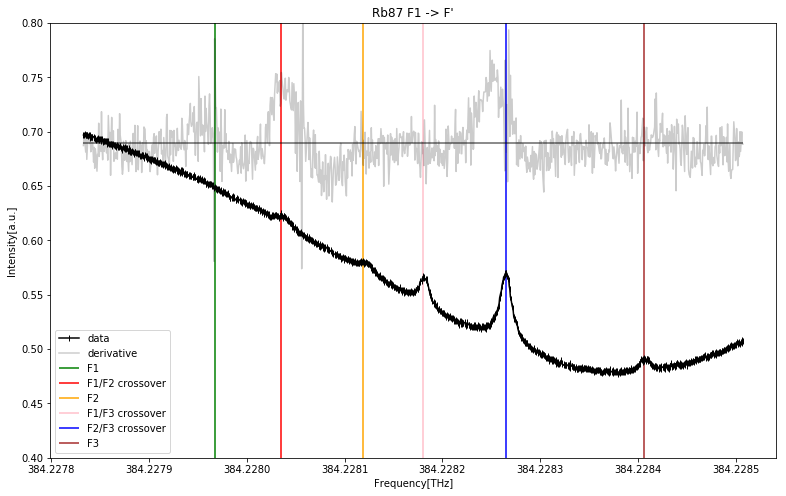

F2-F1: Measured Difference: 151.904 MHz | Theoretical Value: 156.861  MHz | Deviation: 4.957  MHz
F3-F1: Measured Difference: 438.879 MHz | Theoretical Value: 423.593  MHz | Deviation: 15.286  MHz
F3-F2: Measured Difference: 286.974 MHz | Theoretical Value: 266.732  MHz | Deviation: 20.242  MHz


In [598]:
t_p,t,i,d = readout('Rb87_F2',14)
t = scaling(t)
t_p = scaling(t_p)
d_draw = d*0.4*1e-4+0.7

plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')
t_f = [t[d_draw > 0.77][0],t_p[0],t_p[1],t_p[2],t_p[3],t_p[5]]
plt.vlines(t_f[0],0.2,0.8,color='green',label='F1')
plt.vlines(t_f[1],0.2,0.8,color='red',label='F1/F2 crossover')
plt.vlines(t_f[2],0.2,0.8,color='orange',label='F2')
plt.vlines(t_f[3],0.2,0.8,color='pink',label='F1/F3 crossover')
plt.vlines(t_f[4],0.2,0.8,color='blue',label='F2/F3 crossover')
plt.vlines(t_f[5],0.2,0.8,color='brown',label='F3')

plt.hlines(np.average(d_draw),t[0],t[-1],alpha=0.6)
plt.plot(t,d_draw,'k-',alpha=0.2,label='derivative')

plt.ylim(0.4,0.8)
plt.title('Rb87 F1 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()

print('F2-F1: Measured Difference:', round((t_f[2]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_87-p1_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[2]-t_f[0])*1e6,3)-round((p2_87-p1_87)*1e-6,3)),3),' MHz')
print('F3-F1: Measured Difference:', round((t_f[5]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p3_87-p1_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[0])*1e6,3)-round((p3_87-p1_87)*1e-6,3)),3),' MHz')
print('F3-F2: Measured Difference:', round((t_f[5]-t_f[2])*1e6,3), 'MHz | Theoretical Value:',
      round((p3_87-p2_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[2])*1e6,3)-round((p3_87-p2_87)*1e-6,3)),3),' MHz')

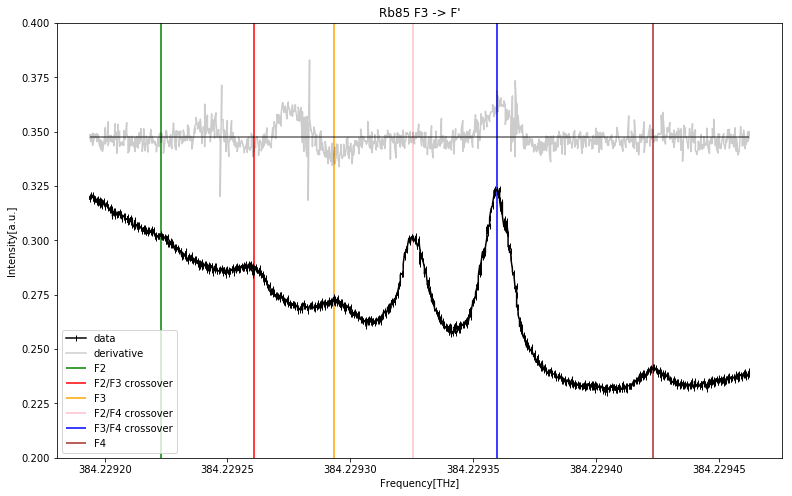

F3-F2: Measured Difference: 70.431 MHz | Theoretical Value: 63.39  MHz | Deviation: 7.041  MHz
F4-F2: Measured Difference: 200.396 MHz | Theoretical Value: 184.04  MHz | Deviation: 16.356  MHz
F4-F3: Measured Difference: 129.965 MHz | Theoretical Value: 120.65  MHz | Deviation: 9.315  MHz


In [599]:
t_p,t,i,d = readout('Rb85_F3',10)
t = scaling(t)
t_p = scaling(t_p)
d_draw = d*0.1*1e-4+0.35

plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

t_f = [t_p[1],t[250],t_p[3],t[490],t[615],t[852]]
plt.vlines(t_f[0],0.2,0.8,color='green',label='F2')
plt.vlines(t_f[1],0.2,0.8,color='red',label='F2/F3 crossover')
plt.vlines(t_f[2],0.2,0.8,color='orange',label='F3')
plt.vlines(t_f[3],0.2,0.8,color='pink',label='F2/F4 crossover')
plt.vlines(t_f[4],0.2,0.8,color='blue',label='F3/F4 crossover')
plt.vlines(t_f[5],0.2,0.8,color='brown',label='F4')

plt.hlines(np.average(d_draw),t[0],t[-1],alpha=0.6)
plt.plot(t,d_draw,'k-',alpha=0.2,label='derivative')

plt.ylim(0.2,0.4)
plt.title('Rb85 F3 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('F3-F2: Measured Difference:', round((t_f[2]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_85-p1_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[2]-t_f[0])*1e6,3)-round((p2_85-p1_85)*1e-6,3)),3),' MHz')
print('F4-F2: Measured Difference:', round((t_f[5]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p3_85-p1_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[0])*1e6,3)-round((p3_85-p1_85)*1e-6,3)),3),' MHz')
print('F4-F3: Measured Difference:', round((t_f[5]-t_f[2])*1e6,3), 'MHz | Theoretical Value:',
      round((p3_85-p2_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[2])*1e6,3)-round((p3_85-p2_85)*1e-6,3)),3),' MHz')

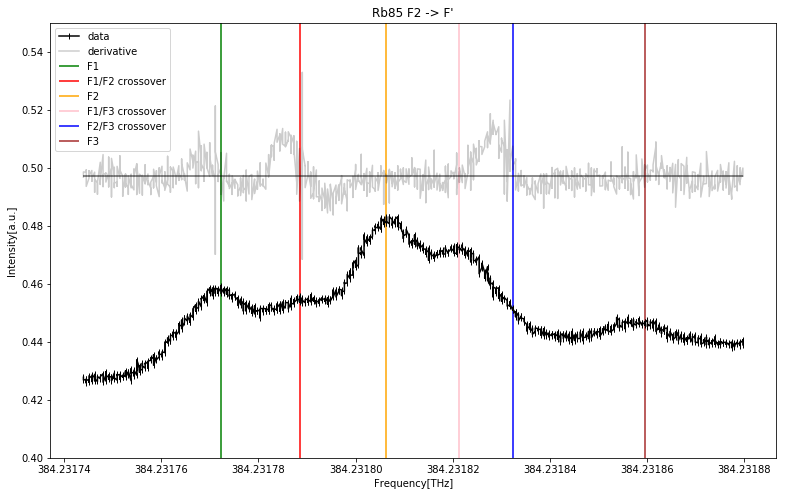

F3-F2: Measured Difference: 34.07 MHz | Theoretical Value: 29.373  MHz | Deviation: 4.697  MHz
F4-F2: Measured Difference: 87.195 MHz | Theoretical Value: 92.763  MHz | Deviation: 5.568  MHz
F4-F3: Measured Difference: 53.125 MHz | Theoretical Value: 63.39  MHz | Deviation: 10.265  MHz


In [600]:
t_p,t,i,d = readout('Rb85_F2',10)
t = scaling(t)
t_p = scaling(t_p)
d_draw = d*0.1*1e-4+0.5

plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

t_f = [t_p[2],t_p[4],t[460],t[570],t[650],t[849]]
plt.vlines(t_f[0],0.2,0.8,color='green',label='F1')
plt.vlines(t_f[1],0.2,0.8,color='red',label='F1/F2 crossover')
plt.vlines(t_f[2],0.2,0.8,color='orange',label='F2')
plt.vlines(t_f[3],0.2,0.8,color='pink',label='F1/F3 crossover')
plt.vlines(t_f[4],0.2,0.8,color='blue',label='F2/F3 crossover')
plt.vlines(t_f[5],0.2,0.8,color='brown',label='F3')
#plt.vlines(t[850],0.2,0.8,color='green')

plt.hlines(np.average(d_draw),t[0],t[-1],alpha=0.6)
plt.plot(t,d_draw,'k-',alpha=0.2,label='derivative')

plt.ylim(0.4,0.55)
plt.title('Rb85 F2 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=2)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('F3-F2: Measured Difference:', round((t_f[2]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p1_85-p0_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[2]-t_f[0])*1e6,3)-round((p1_85-p0_85)*1e-6,3)),3),' MHz')
print('F4-F2: Measured Difference:', round((t_f[5]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_85-p0_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[0])*1e6,3)-round((p2_85-p0_85)*1e-6,3)),3),' MHz')
print('F4-F3: Measured Difference:', round((t_f[5]-t_f[2])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_85-p1_85)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[2])*1e6,3)-round((p2_85-p1_85)*1e-6,3)),3),' MHz')

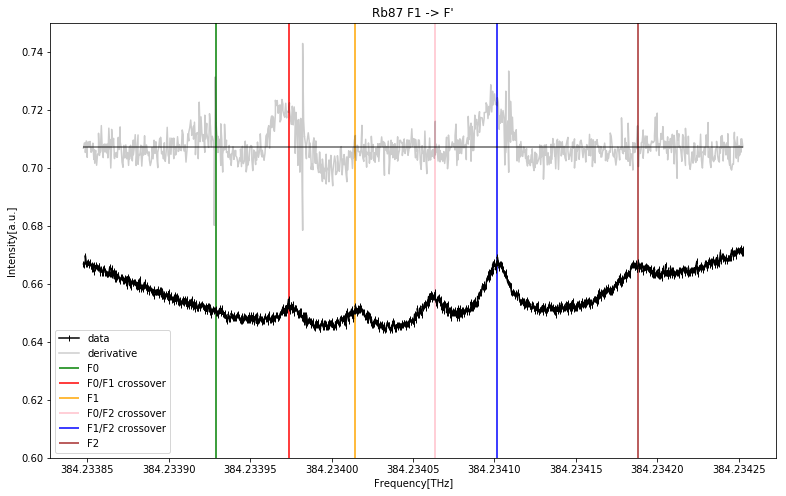

F1-F0: Measured Difference: 85.498 MHz | Theoretical Value: 72.222  MHz | Deviation: 13.276  MHz
F2-F0: Measured Difference: 259.293 MHz | Theoretical Value: 229.083  MHz | Deviation: 30.21  MHz
F2-F1: Measured Difference: 173.794 MHz | Theoretical Value: 156.861  MHz | Deviation: 16.933  MHz


In [601]:
t_p,t,i,d = readout('Rb87_F1',10)
t = scaling(t)
t_p = scaling(t_p)
d_draw = d*0.1*1e-4+0.71

plt.figure(figsize=(13,8))
plt.plot(t,i,'k|-',label='data')

t_f = [t[200],t_p[5],t_p[7],t_p[9],t_p[10],t_p[14]]
plt.vlines(t_f[0],0.2,0.8,color='green',label='F0')
plt.vlines(t_f[1],0.2,0.8,color='red',label='F0/F1 crossover')
plt.vlines(t_f[2],0.2,0.8,color='orange',label='F1')
plt.vlines(t_f[3],0.2,0.8,color='pink',label='F0/F2 crossover')
plt.vlines(t_f[4],0.2,0.8,color='blue',label='F1/F2 crossover')
plt.vlines(t_f[5],0.2,0.8,color='brown',label='F2')

plt.hlines(np.average(d_draw),t[0],t[-1],alpha=0.6)
plt.plot(t,d_draw,'k-',alpha=0.2,label='derivative')

plt.ylim(0.6,0.75)
plt.title('Rb87 F1 -> F\'')
plt.ylabel('Intensity[a.u.]')
plt.xlabel('Frequency[THz]')
plt.legend(loc=3)
plt.gca().get_xaxis().get_major_formatter().set_useOffset(False)
plt.show()
print('F1-F0: Measured Difference:', round((t_f[2]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p1_87-p0_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[2]-t_f[0])*1e6,3)-round((p1_87-p0_87)*1e-6,3)),3),' MHz')
print('F2-F0: Measured Difference:', round((t_f[5]-t_f[0])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_87-p0_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[0])*1e6,3)-round((p2_87-p0_87)*1e-6,3)),3),' MHz')
print('F2-F1: Measured Difference:', round((t_f[5]-t_f[2])*1e6,3), 'MHz | Theoretical Value:',
      round((p2_87-p1_87)*1e-6,3),' MHz | Deviation:', 
     round(np.abs(round((t_f[5]-t_f[2])*1e6,3)-round((p2_87-p1_87)*1e-6,3)),3),' MHz')